# Goals
For each version of the data (z-normalization, log-transform and binarization) from the Data
Processing section, implement a KNN classifier.

For each value of K = {1, 2, · · · , 9, 10, 15, 20, · · · , 95, 100} (note the jump in interval from
10 to 15 and beyond), compute the training and test error rates (i.e., percentage of emails
classified wrongly).

For the continuous data (z-normalization, log-transform) use the Euclidean distance to measure
distance between neighbors. For the binarized data, use the Hamming distance

# Data Description

The data is an email spam dataset, consisting of 4601 email messages with 57 features. Feature descriptions are found in this [link](https://web.stanford.edu/~hastie/ElemStatLearn/datasets/spam.info.txt). We have divided the data into a training set (3605 emails) and test set (1536 emails) with accompanying labels (1=spam,0=not spam)

# Setup

In [1]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.display import HTML
from sklearn.neighbors import DistanceMetric

# A function to enable displaying the tables side by side
def multi_table(table_list):
    ''' Acceps a list of IpyTable objects and returns a table which contains each IpyTable in a cell
    '''
    return HTML(
        '<table><tr style="background-color:white;">' + 
        ''.join(['<td>' + table._repr_html_() + '</td>' for table in table_list]) +
        '</tr></table>'
    )

# set seaborn style
sns.set()

# display 6 digit decimal float in Pandas DataFrame
pd.set_option('display.float_format', lambda x: '%.5f' % x)

# Implementation

## 1. Import the data

Import the training dataset.

In [2]:
# Creating a DataFrame from csv file for Xtrain. 
df_X = pd.read_csv('spamData_Xtrain.csv',header=None)
# Creating a DataFrame from csv file for ytrain.
df_y = pd.read_csv('spamData_ytrain.csv',header=None)

Import the test dataset

In [3]:
# Creating a DataFrame from csv file for Xtest. 
df_Xtest = pd.read_csv('spamData_Xtest.csv',header=None)
# Creating a DataFrame from csv file for ytest.
df_ytest = pd.read_csv('spamData_ytest.csv',header=None)

`N`: Number of training samples

In [4]:
N = len(df_X)

`D`: Number of training sample features

In [5]:
D = df_X.shape[1]

## 2. Process the data

Three preprocessing technique could be considered:

### 2.1 Z-Normalization

In [6]:
def stdev(column):
    avg = np.mean(column)
    sd  = np.sum(np.square(column-avg))/(len(column)-1)
    return np.sqrt(sd)

def z_norm(column):
    column = column - np.mean(column)
    column = column/stdev(column)
    return column

### 2.2 Log-Transformation 
Transform each feature using $\log(x_{i,j}+0.1)$ (assume natural log)

The log transformation can be used to make highly skewed distributions less skewed.

In [7]:
# df_X = np.log(df_X+0.1)

### 2.3 Binarization

In [8]:
def Binarize(column):
    """For the input column, set values larger than the column mean to be 1, 
    rest set to be 0."""
    ones = column > column.mean()
    zeros = column <= column.mean()
    columnNew = pd.Series(np.zeros(len(column)))
    columnNew[ones] = 1
    return columnNew

### 2.4 Preprocess the training and test dataset

I'll use binarization in this case.

In [9]:
df_X = df_X.apply(Binarize)

In [10]:
df_Xtest = df_Xtest.apply(Binarize)

___

## 3. Make Prediction for One Sample

In [11]:
# use sklearn to calculate hamming distance.
dist = DistanceMetric.get_metric('hamming')

In [12]:
def predict(X_train, y_train, X_test_one, k):
    """Find out the K nearest neighbors and make predictions about the class the sample belong to."""
    # Calculat the euclidean distance 
    distance = dist.pairwise(X_train,X_test_one)
    
    # find out the index of the k nearest neighbors
    index = np.argsort(distance,axis=0)[:k]
    index_list = []
    for i in index.tolist():
        index_list = index_list+i
    
    # find out the labels of the k nearest neighbors
    k_nearest_neighbors = y_train.iloc[index_list]
    
    # the majority vote
    prediction = k_nearest_neighbors.mode().values[0][0] 
    
    return prediction #, index, k_nearest_neighbors

Let's see if the `predict` function can correctly predict the first three samples from the training dataset

In [13]:
# The label of the first three samples from the training dataset.
df_y.head(3)

,0
0,1
1,0
2,0


In [14]:
# The first sample from the training dataset.
test_prediction = predict(df_X,df_y,df_X.iloc[[0]],5)
print('Prediction of the first sample from the training dataset:',test_prediction)

Prediction of the first sample from the training dataset: 1


In [15]:
# The first sample from the training dataset.
test_prediction = predict(df_X,df_y,df_X.iloc[[1]],5)
print('Prediction of the second sample from the training dataset:',test_prediction)

Prediction of the second sample from the training dataset: 0


In [16]:
# The first sample from the training dataset.
test_prediction = predict(df_X,df_y,df_X.iloc[[2]],5)
print('Prediction of the third sample from the training dataset:',test_prediction)

Prediction of the third sample from the training dataset: 0


Looks good. Let's move on. 

## 4. Make Predictions for all Samples in a Dataset

In [17]:
def knn(X_train,y_train,X_test,k):
    """make predictions for all samples in the dataset X_test, based on training dataset X_train and y_train."""
    predictions = []
    
    # apply predict function for every sample from X_test.
    for i in range(len(X_test)):
        predictions.append(predict(X_train,y_train,X_test.iloc[[i]],k))
    
    predictions = pd.DataFrame(predictions)
    return predictions

Again, let's see whether the `knn` function can predict the first 10 samples from the training dataset correctly.

In [18]:
test = df_X.head(10)

In [19]:
predictions = knn(df_X,df_y,test,5)

Manually compare the predictions with the first 10 samples from the training dataset.

In [20]:
multi_table([predictions,df_y.head(10)])

,0
0,1
1,0
2,0
3,0
4,0
5,0
6,1
7,0
8,1
9,0


The predictions are all correct.

___

## 5. Calculate Error Rate

In [21]:
def getErrorRate(prediction,y):
    """Calculate the percentage of emails classified wrongly"""
    compare = prediction == y
    errorRate = 1-compare.sum().values[0]/compare.shape[0]
    return errorRate

Let's see what is the error rate when K = 1,10 and 100

$K = 1$

In [22]:
predictions_1 = knn(df_X,df_y,df_X,1)

In [23]:
getErrorRate(predictions_1,df_y)

0.011745513866231683

$K = 10$

In [24]:
predictions_10 = knn(df_X,df_y,df_X,10)

In [25]:
getErrorRate(predictions_10,df_y)

0.075367047308319779

$K = 100$

In [26]:
predictions_100 = knn(df_X,df_y,df_X,100)

In [27]:
getErrorRate(predictions_100,df_y)

0.14029363784665583

## 6. Get the Error Rate for K = {1,2,...,9,10,15,20,...,95,100}

In [28]:
K = np.append(np.arange(1,10),np.arange(10,105,5))

__`df_error_rate`__: a dataframe used to store the error rate for each k value. 

In [29]:
df_error_rate = pd.DataFrame(np.zeros((len(K),2)),index = K,columns=['train','test'])

### 6.1 Make predictions for the "Training Dataset" and calculate error rate.

In [30]:
for k in K:
    predictions = knn(df_X,df_y,df_X,k)
    df_error_rate.loc[k,'train'] = getErrorRate(predictions,df_y)

### 6.2 Make predictions for the "Test Dataset" and calculate error rate.

In [31]:
for k in K:
    predictions = knn(df_X,df_y,df_Xtest,k)
    df_error_rate.loc[k,'test'] = getErrorRate(predictions,df_ytest)

In [32]:
# Save the error rates to a csv file.
df_error_rate.to_csv('Q4_ErrorRates_Binary.csv')

In [37]:
print('\nThe error rate when K = 1,10 and 100 is\n',df_error_rate.loc[[1,10,100]])


The error rate when K = 1,10 and 100 is
       train    test
1   0.01175 0.08724
10  0.07537 0.08398
100 0.14029 0.11914


In [33]:
df_error_rate.describe()

,train,test
count,28.00000,28.00000
mean,0.09451,0.09668
std,0.03348,0.01379
min,0.01175,0.07617
25%,0.07210,0.08366
50%,0.09331,0.09473
75%,0.12618,0.10921
max,0.14029,0.11914


## 7. Plot the Graph: Error Rates versus $\lambda$

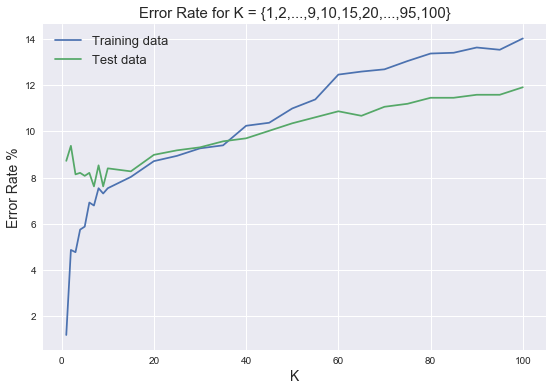

In [34]:
# set the figure size
fig=plt.figure(figsize=(9,6))

# x axis: the regularization parameters lambda.
x = df_error_rate.index.values
# y axis: the error rates
y1 = 100*df_error_rate.train.values
y2 = 100*df_error_rate.test.values

_ = plt.plot(x, y1)
_ = plt.plot(x, y2)

plt.title('Error Rate for K = {1,2,...,9,10,15,20,...,95,100}',fontsize=15)
plt.xlabel('K', fontsize=14)
plt.ylabel('Error Rate %', fontsize=14)

# legend
plt.legend(('Training data', 'Test data'),fontsize=13)

plt.show()

__ Why is training error not 0 when k = 1? __

My guess would be, in the training dataset, some emails are labeled several times, and sometimes labeled as spam and sometimes as non-spam. 

Let's verify it.

In [35]:
df_distance = pd.DataFrame(dist.pairwise(df_X,df_X))

In [36]:
df_y[df_distance[2] == 0]

,0
2,0
2288,0
2490,1


This proves that my guess is correct. 

This means that the second sample from the training dataset is labeled three times. It was labeled as non-spam in the first two times and was labeld as spam in the last time.  

___